# Downloading Dataset from kaggle and storing it in Google drive

In [ ]:
# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [ ]:
!pip install kaggle

In [ ]:
# Navigate into Drive where you want to store your Kaggle data
os.chdir('/content/drive/MyDrive/Deep Learning/CNN/Siamese network')
# Paste and run the copied API command, the data will download to the current directory
!kaggle datasets download -d moltean/fruits
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

100% 759M/760M [00:06<00:00, 128MB/s]
100% 760M/760M [00:06<00:00, 118MB/s]


['Siamese_network.ipynb', 'fruits.zip']

In [ ]:
Archive=r'/content/drive/MyDrive/Deep Learning/CNN/Siamese network/fruits.zip'
from zipfile import ZipFile
with ZipFile(Archive,'r') as z:
    z.extractall()
print('Archive Extraction done')

Archive Extraction done


# Importing Libraries

**Summary**


Siamese Networks are a class of neural networks capable of one-shot learning. This post is aimed at deep learning beginners, who are comfortable with python and the basics of convolutional neural networks. We will go through line by line explanation of how siamese networks are implemented using Keras in Python. When you are going through the code, in case you feel some things could have been explained or done in a better way, feel free to comment.


**Introduction**

Let us assume we have a company of 1000 employees. We decide to implement a facial recognition system to record the attendance of your employees. If we were to use traditional neural networks, we will have to face two main problems. First one would be the dataset. It would be nearly impossible to assemble a huge collection of dataset from each of our employees, we would end up with a maximum of 5 photos of each of our employees. But a traditional CNN(Convolutional Neural Networks) won’t be able to learn features with such small collection. We’ll also end up with 1000 output classes. Let’s consider that somehow we got a huge dataset from each of our employees and we trained a really good CNN model. What happens when a new employee joins our organization? How can we include the person into our facial recognition system? All these shortcomings can be overcome using siamese networks. In this post, we will experiment with one-shot learning using Siamese networks that concentrate on the difference rather than feature matching.

Rather than using huge data for each of the class, we calculate the similarity scores between images of different classes. The input to this network will be two images either belonging to the same class or different class. The output will be a floating-point number ranging between 0 and 1, wherein 1 indicates that that the two images are of the same class and 0 indicating they are from different ones. Let me start by explaining how it is different from image classification using CNN Architectures.

Architecture

In case of a CNN model, you have a series of convolutional and pooling layers followed by some dense layers and an output layer probably with a softmax function. The convolutional layers here are responsible for feature extraction from the image, whereas the softmax layer is responsible for providing a range of probability for every class. We then decide the class of the image with the neuron that has the highest probability value.
Take a look at this great article for more information on how CNN works.


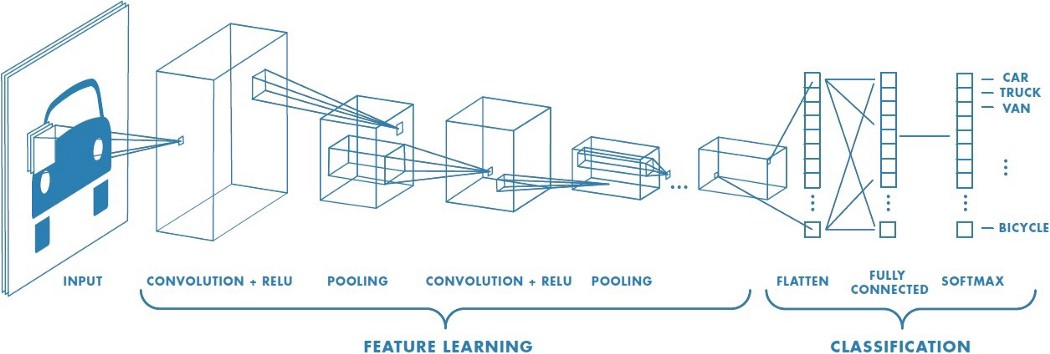

With siamese networks, it has a similar constitution of convolutional and pooling layers except we don’t have a softmax layer. So, we stop with the dense layers. As explained before since the network has two images as inputs, we will end up with two dense layers. Now we calculate the difference of these two layers and output the result to a single neuron with sigmoid activation function(0 to 1). Thus the training data to this network must be structured in such a way that there is a list consisting of two images and a variable either 0 or 1.


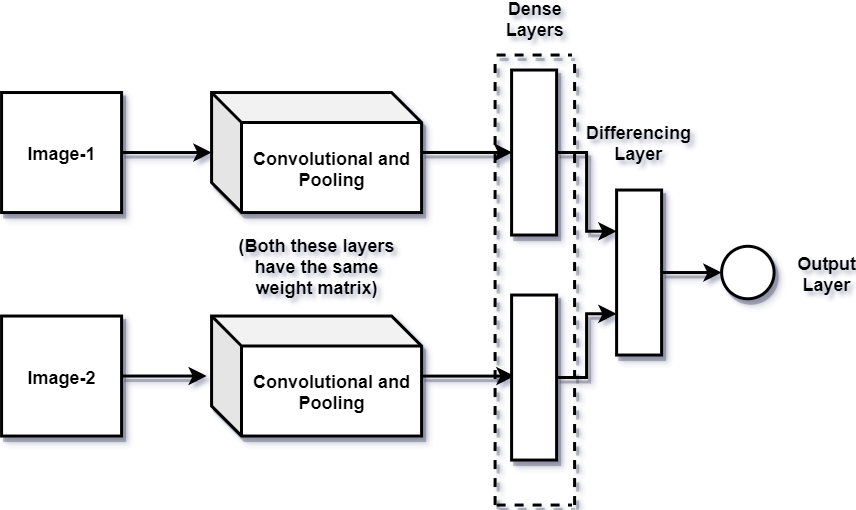

https://towardsdatascience.com/siamese-networks-line-by-line-explanation-for-beginners-55b8be1d2fc6

Note: There is only one network and both the images are passed through the same network. It’s just that there are two inputs. Thus, both the inputs will be passing through the same weight matrix from the convolution and dense layers.
If you are still not clear of how this works, refer to this link.
Code

For this post, I have used Fruits 360 dataset from Kaggle. However, feel free to experiment with other datasets. The code is hosted in Kaggle. In case you have some doubts with the code, feel free to fork the below notebook and experiment yourself.
https://www.kaggle.com/krishnaprasad96/siamese-network


**Importing Libraries**

Let us start by importing the libraries that we are using. As mentioned before this code uses Keras for building the model and NumPy, pillow for data preprocessing.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model

# Data Preprocessing

In [ ]:
base_dir = r'/content/drive/MyDrive/Deep Learning/CNN/Siamese network/fruits-360/Training'
train_test_split = 0.7
no_of_files_in_each_class = 10

#Read all the folders in the directory
folder_list = os.listdir(base_dir)
print( len(folder_list), "categories found in the dataset")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

#Using just 5 images per category
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape)

131 categories found in the dataset
X, Y shape (1310, 100, 100, 3) (1310,) (131, 10)


Line 1: Include the base directory of the dataset

Line 2: Indicate the percentage that is going to be used for training. The rest will be used for testing

Line 3: Since Fruits 360 is a dataset for Image classification, It has a lot of images per category. But for our experiment, a small portion is enough

Line 6: Get the list of directories from the folder. Each folder pertains to class

Line 10–13: Declare three empty lists to record X(images), y(labels), cat_list(To record the category of each image)

Line 16–24: Iterate over the class folders and select ten images from each of the class, convert them to RGB format and append them to a list. keep a record of the class of the image in cat_list[] for further reference

Line 26–28: Convert all the list to NumPy arrays. As any image will range from 0–255, divide the array x by 255 for simplification

# Train test split

In [ ]:
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X&Y shape of testing data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)

91 classes for training and 40  classes for testing
X&Y shape of training data : (910, 100, 100, 3) and (910,) (91, 10)
X&Y shape of testing data : (400, 100, 100, 3) and (400,) (40, 10)


Line 1: Calculate the number of classes that will be used for training by multiplying with the train_test_split

Line 2: Subtract train_size from the total classes available to get the test_size

Line 4: Multiply train_size with the number of files in each class to get the total number of training files

Line 7–15: Use the value calculated before to subset X, Y and cat_list

**Generating Batch**

This Section is for generating batch files for training. The Batch files should have an X and Y. In the usual case of image classification, If the batch size is 64 and the image size is (100, 100, 3) the size of X would be a list of size 64 and each element in the list would be of size (100, 100, 3).

In our case since we have 2 inputs, there would be a list (let’s say ‘A’) of size 64 and each element in ‘A’ would have a list (let’s say ‘B’) of length 2 and each element in ‘B’ would be of size (100, 100, 3). For training, we’ll generate a batch such that for half the input pairs B[0] and B[1] are of the same category. Assign the value 0 to these image pairs. For the other half of the input pairs, B[0] and B[1] are of different category. Assign the value 1 to these image pairs.


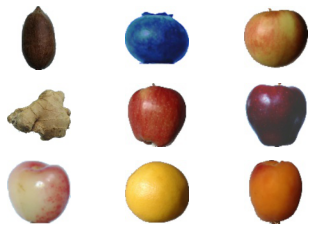

In [ ]:
#Plotting Images
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(x_train[np.random.randint(0, x_train.shape[0]-1)])
plt.show()

# Generating Batch

In [ ]:
def get_batch(batch_size=64, call_type='train'):
    
    temp_x = None
    temp_cat_list = None
    start=None
    end=None
    batch_x=[]
    
    if call_type == 'train':
        temp_x = x_train
        temp_cat_list = cat_train
        start=0
        end = train_size
    else:
        temp_x = x_val
        temp_cat_list = cat_test
        start = train_size+1
        end = len(folder_list)-1
        
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(start, end, batch_size) 
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]  
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            
    return(batch_x, batch_y)

Line 3–7: Store the values of x_train, cat_train and the start and end size of training size in a temporary variable

Line 9–11: Assign half of the batch_size of Y as 0 and others as 1

Line 13: Generate a random list of classes from the training category list to be used. Also, append two arrays of image_size*batch_size

Line 17–25: For each iteration, In case of batch_x[0] select an image from the category specified in the class list. For batch_x[1] select an image from the same category if y[i] is 0, else select batch_x[1] from any other category except for the same one

# Siamese Network

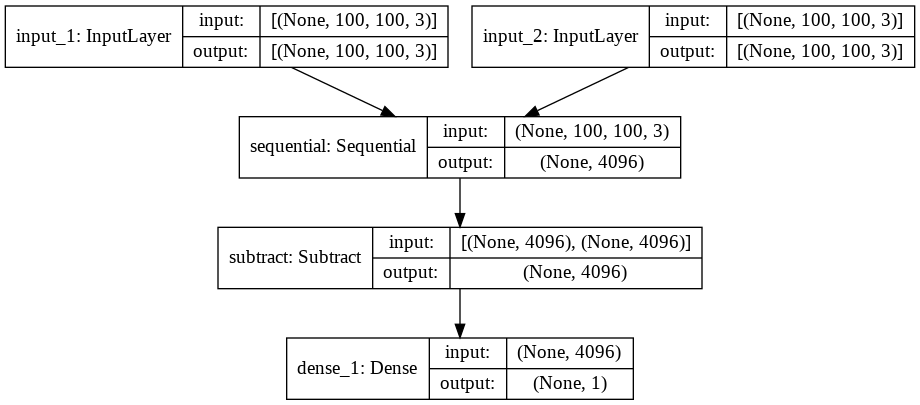

In [ ]:
#Building a sequential model
input_shape=(100, 100, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (7,7), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(256, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init)
])

encoded_l = model(left_input)
encoded_r = model(right_input)

# L1_distance = lambda x: K.abs(x[0] - x[1])
# print(type(L1_distance))
# both = merge([encoded_l, encoded_r], mode=L1_distance, output_shape = lambda x:x[0])
subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

optimizer= Adam(learning_rate=0.0006)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

plot_model(siamese_net, show_shapes=True, show_layer_names=True)

Line 1: Declare the shape of the input image.

Line 2: Declare two inputs with the shape of the image.

Line 6–7: Declare parameters for initializing weight and bias of the network. The values are chosen as described in the paper.

Line 9–20: Declare a Sequential model with 4 convolutional layers and max-pooling layers. Use a flattening layer at last followed by a dense layer.

Line 22–23: Pass both the inputs to the same model.

Line 25–27: Subtract the dense layers from both the images and pass it through a single neuron with a sigmoid activation function.

Line 29–30: Compile the model with loss as ‘binary_cross_entropy’ and ‘Adam’ optimizer.

Line 32: The plot model function for siamese_net outputs the following.

# N-way One shot learning

This is a process of validating one-shot learning, we pick ’n’ input pairs such that only one input pair belong to the same category and other all are from different ones. If we consider a 9-way one-shot validation, and each input to the network requires two images, x[0] remains constant for all 9 pairs, x[1] belongs to the same category of x[0] only for 1 in 9 pairs, and different for everything else. If all the 9 pairs are given to the model, it is expected that the pair which belong to the same category will have the lowest value out of the 9 pairs. In such a case, we count it as a successful prediction.

The input parameter n_val refers to the number of validation steps. n_way refers to the number of ways for each validation step. Remember that x[0] mentioned above remains constant for every validation step.

In [ ]:
def nway_one_shot(model, n_way, n_val):
    
    temp_x = x_val
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(train_size+1, len(folder_list)-1, n_val)

    for i in class_list:  
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 100, 100, 3)))
        temp.append(np.zeros((n_way, 100, 100, 3)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            
            if k==0:
                #print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                #print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy

In [ ]:
nway_one_shot(model, 5, 7)

0 correctly classified among 7


0.0

Line 3–7: Store x_val, cat_test in a temporary variable

Line 9: This is the same as Line 13 in the batch generation, except we create a batch of random categories from the test set

Line 11–24: For each validation step, we iterate through the n_way, take the corresponding category list from class_list, pick an image from that category and store it in x[0]. For x[1] select an image from the same category if it is the first iteration, and select from a different category for others. This inner loop is almost the same as batch_generation() method discussed above.

Line 26–31: For each of the validation step, predict the output using the model and check if result[0] has the minimum value compared to others. Note that the result array will be a list of size n_way. If yes add 1 to n_correct. Repeat the same for all other validation steps.

Line 32: Calculate the accuracy using n_correct and the number of validation steps.

Training the Model
Training the model has 4 hyperparameters (epochs, batch_size, n_val, n_way)

# Model Training

In [ ]:
epochs = 5000
n_way = 20
n_val = 100
batch_size = 64

loss_list=[]
accuracy_list=[]
for epoch in range(1,epochs):
    batch_x, batch_y = get_batch(batch_size, call_type="train")
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch,loss))
    print('Epoch:', epoch, ', Loss:',loss)
    if epoch%50 == 0:
        print("=============================================")
        accuracy = nway_one_shot(model, n_way, n_val)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>99):
            print("Achieved more than 90% Accuracy")
            #break

Line 6–7: Declare two lists to record the loss and accuracy values for further visualizations.

Line 8–20: For each epoch, get the batch of x and y, train the model using those inputs and append the loss to the list. For every ’n’ (250 in this case) number of epochs, check how the model is performing by doing N-way one-shot learning.

**Results and Future works**

The above code was trained for 5000 epochs in google colab. Using a GPU would significantly reduce the training time.